In [1]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import skimage
from skimage.transform import AffineTransform
from matplotlib.transforms import Affine2D
from skimage.transform import resize
import random
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

In [2]:
def save_model(model):
    input_type = FloatTensorType([None, (100 * 100)])
    input_name = "float_input"
    initial_type = [(input_name, input_type)]
    onx = convert_sklearn(
        model,
        initial_types=initial_type,
        verbose=1,
        options={type(model): {"zipmap": False}},
    )

    # Add class labels to the model metadata
    metadata_props = {
        "classlabels": json.dumps(model.classes_.tolist()),
    }
    for key, value in metadata_props.items():
        onx.metadata_props.add()
        onx.metadata_props[-1].key = key
        onx.metadata_props[-1].value = value

    file_name = "hwemoji2.onnx"
    with open(file_name, "wb") as f:
        f.write(onx.SerializeToString())
    

def resize_100x100(data):
    return list(map(lambda sample: resize(sample, (100, 100), anti_aliasing=False), data))

def pointsTo2DImage(points):
    input_size = 400
    black_and_white_points = np.zeros((input_size, input_size))
    for point in points:
        x = int(point["x"])
        y = int(point["y"])
        point_inside_the_matrix = (
            x < input_size and y < input_size and x >= 0 and y >= 0
        )
        if point_inside_the_matrix:
            black_and_white_points[y][x] = 1
    return black_and_white_points


def remove_padding_single(image_array):
    """
    Crop a 2D numpy array to remove empty borders (all zeros).
    
    This function finds the smallest bounding box that contains all non-zero pixels
    in the image and returns that cropped region.
    
    Args:
        image_array: 2D numpy array representing an image
        
    Returns:
        Cropped numpy array with empty borders removed, or empty array if input is all zeros
    """
    # Find rows that contain at least one non-zero value
    non_empty_rows = image_array.any(axis=1)
    
    # If the array has no non-zero values, return an empty array
    if not non_empty_rows.any():
        return np.empty((0, 0), dtype=image_array.dtype)
    
    # Find columns that contain at least one non-zero value
    non_empty_columns = image_array.any(axis=0)
    
    # Get the dimensions of the array
    height, width = image_array.shape
    
    # Find the first and last non-empty row
    first_non_empty_row = non_empty_rows.argmax()
    last_non_empty_row = height - np.flip(non_empty_rows).argmax()
    
    # Find the first and last non-empty column
    first_non_empty_column = non_empty_columns.argmax()
    last_non_empty_column = width - np.flip(non_empty_columns).argmax()
    
    # Return the cropped image that contains only the non-empty region
    return image_array[
        first_non_empty_row:last_non_empty_row, 
        first_non_empty_column:last_non_empty_column
    ]

def remove_padding(data):
    return list(map(remove_padding_single, data))

def create_evaluate_model(data, labels):
	model = LogisticRegression(n_jobs=os.cpu_count(), verbose=True, random_state=42)
	train, test, lables_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)

	train_flat = [x.flatten() for x in train]
	test_flat = [x.flatten() for x in test]

	model.fit(train_flat, lables_train)
	print(model.score(test_flat, labels_test))
	return model


'❤'

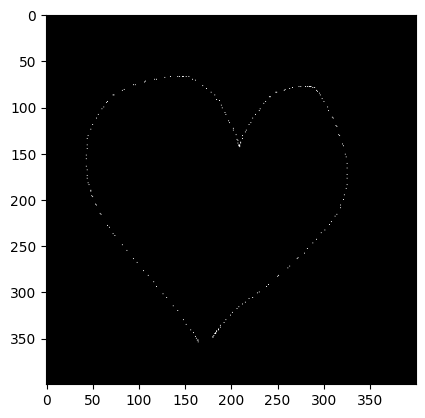

In [3]:
dataset_path = 'emoji_dataset.json'

data = []
labels = []

raw_data = json.loads(open(dataset_path, 'r', encoding='utf-8').read())
for sample in raw_data:
    label = sample['emoji']

    sample_image = pointsTo2DImage(sample['points'])

    data.append(sample_image)
    labels.append(label)
        

plt.imshow(data[1], cmap='gray')
labels[0]

In [4]:
data_simple = resize_100x100(remove_padding(data))
create_evaluate_model(data_simple, labels)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


0.7


LogisticRegression(n_jobs=8, random_state=42, verbose=True)

In [5]:
def augment_scale(sample):
    augmented_samples = []
    sample_flipped_horizontally = np.fliplr(sample)
    augmented_samples.append(sample_flipped_horizontally)
    scale_values = [1.30, 1.20, 1.10, 0.9, 0.8, 0.7]
    for scale in scale_values:
        matrix = Affine2D().scale(sx=scale, sy=1).get_matrix()
        scale_transform = AffineTransform(matrix=matrix)
        rescaled_sample = skimage.transform.warp(sample, scale_transform.inverse)
        augmented_samples.append(rescaled_sample)
    for scale in scale_values:
        matrix = Affine2D().scale(sx=1, sy=scale).get_matrix()
        scale_transform = AffineTransform(matrix=matrix)
        rescaled_sample = skimage.transform.warp(sample, scale_transform.inverse)
        augmented_samples.append(rescaled_sample)
    return augmented_samples


def rotate_point_around_center(x, y, degrees):
    angle = np.radians(degrees)
    point_to_be_rotated = (x, y)
    center_point = (200, 200)
    xnew = (
        np.cos(angle) * (point_to_be_rotated[0] - center_point[0])
        - np.sin(angle) * (point_to_be_rotated[1] - center_point[1])
        + center_point[0]
    )
    ynew = (
        np.sin(angle) * (point_to_be_rotated[0] - center_point[0])
        + np.cos(angle) * (point_to_be_rotated[1] - center_point[1])
        + center_point[1]
    )
    return (round(xnew, 2), round(ynew, 2))


def introduce_noise(x, y):
    newx = x + random.randint(-5, 5)
    newy = y + random.randint(-5, 5)
    return (newx, newy)


def normalized_value(x):
    if x >= 0.01:
        return 1
    else:
        return 0


map_to_zero_or_one = np.vectorize(normalized_value, otypes=[float])

def augment_rotate(raw_sample):
    augmented_samples = []
    rotate_values = list(range(-45, 50, 5))
    
    for rotation_angle in rotate_values:
        rotated_sample = []
        for points in raw_sample:
            new_x, new_y = rotate_point_around_center(
                points["x"], points["y"], rotation_angle
            )
            rotated_sample.append({"x": new_x, "y": new_y})
        augmented_samples.append(pointsTo2DImage(rotated_sample))

    return augmented_samples


In [6]:
data_aug_scale = []
labels_aug_scale = []

for index, sample in enumerate(data):
	augmented_samples = augment_scale(sample)
	data_aug_scale.extend(augmented_samples)
	labels_aug_scale.extend([labels[index]] * len(augmented_samples))

data_aug_scale = resize_100x100(remove_padding(data_aug_scale))

create_evaluate_model(data_aug_scale, labels_aug_scale)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


0.9730769230769231


LogisticRegression(n_jobs=8, random_state=42, verbose=True)

In [7]:
data_aug_full = data_aug_scale.copy()
labels_aug_full = labels_aug_scale.copy()

for index, raw_sample_points in enumerate(map(lambda x: x['points'], raw_data)):
	augmented_samples = augment_rotate(raw_sample_points)
	data_aug_full.extend(augmented_samples)
	labels_aug_full.extend([labels[index]] * len(augmented_samples))

data_aug_full = resize_100x100(remove_padding(data_aug_full))

model_1 = create_evaluate_model(data_aug_full, labels_aug_full)
save_model(model_1)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


0.9296875
[convert_sklearn] parse_sklearn_model
[convert_sklearn] convert_topology
[convert_operators] begin
[convert_operators] iteration 1 - n_vars=0 n_ops=1
[call_converter] call converter for 'SklearnLinearClassifier'.
[convert_operators] end iter: 1 - n_vars=4
[convert_operators] iteration 2 - n_vars=4 n_ops=1
[convert_operators] end iter: 2 - n_vars=4
[convert_operators] end.
[_update_domain_version] +opset 0: name='ai.onnx.ml', version=1
[convert_topology] +opset: name='', version=21
[convert_sklearn] end
